In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, average_precision_score,
                             roc_curve, roc_auc_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split


import os
import sys
""" Workaround for notebooks to import packages from the parent folder """
# Get the project root directory by navigating up from the current directory
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print("Project root:", project_root)
from tools import config


Project root: c:\Users\Angelo\PycharmProjects\financial_dataset


In [25]:

def evaluate_lr(y_pred, y_proba, y_test):
   # Accuracy, confusion matrix, classification report
   print("Accuracy:", accuracy_score(y_test, y_pred))
   print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
   print("Classification Report:\n", classification_report(y_test, y_pred))

   # (1) Average Precision
   avg_precision = average_precision_score(y_test, y_proba)
   print("Average Precision:", avg_precision)

   # (2) Recall at 100
   top_indices = np.argsort(y_proba)[::-1][:100]
   y_top_100 = y_test.iloc[top_indices]
   recall_at_100 = y_top_100.sum() / y_test.sum()
   print("Recall at 100:", recall_at_100)

   # (3) ROC Curve and AUC
   fpr, tpr, thresholds = roc_curve(y_test, y_proba)
   roc_auc = roc_auc_score(y_test, y_proba)
   print("ROC AUC:", roc_auc)

   # Plot ROC Curve
   plt.figure(figsize=(6, 4))
   plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
   plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
   plt.title("Receiver Operating Characteristic")
   plt.xlabel("False Positive Rate")
   plt.ylabel("True Positive Rate")
   plt.legend()
   plt.show()

# Logistic Regression (Numeric columns only)

In [16]:

# Load the dataset
df = pd.read_csv(config.POST_PROCESSED_DATASET_FILEPATH)

# Drop irrelevant columns
columns_to_drop = [
    'filename',
    'bankruptcy_date_1',
    'bankruptcy_date_2',
    'bankruptcy_date_3',
    'period_of_report',
    'can_label',
    'qualified',
    'filing_date',
    'cik_year',
    'opinion_text', 
    'item_7',
    'gvkey', 
    'datadate',
    'cik',
    'company',
    'gc_list'
]
df.drop(columns=columns_to_drop, axis=1, inplace=True)
print("cols remaining: ", df.columns)


before drop na:  (21740, 26)
df columns at start  Index(['cik', 'company', 'period_of_report', 'gvkey', 'datadate', 'filename',
       'can_label', 'qualified', 'label', 'bankruptcy_prediction_split',
       'bankruptcy_date_1', 'bankruptcy_date_2', 'bankruptcy_date_3',
       'filing_date', 'cik_year', 'opinion_text', 'gc_list', 'item_7',
       'Assets', 'CashAndCashEquivalentsAtCarryingValue',
       'IncomeTaxExpenseBenefit', 'LiabilitiesAndStockholdersEquity',
       'RetainedEarningsAccumulatedDeficit', 'StockholdersEquity',
       'EntityCommonStockSharesOutstanding', 'EntityPublicFloat'],
      dtype='object')
cols remaining:  Index(['label', 'bankruptcy_prediction_split', 'Assets',
       'CashAndCashEquivalentsAtCarryingValue', 'IncomeTaxExpenseBenefit',
       'LiabilitiesAndStockholdersEquity',
       'RetainedEarningsAccumulatedDeficit', 'StockholdersEquity',
       'EntityCommonStockSharesOutstanding', 'EntityPublicFloat'],
      dtype='object')


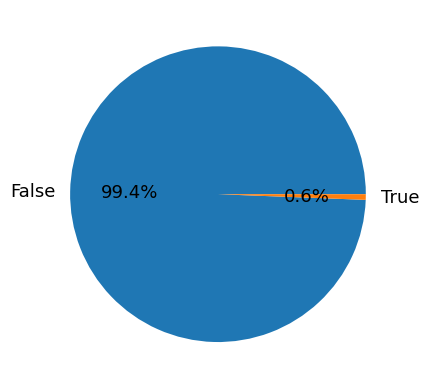

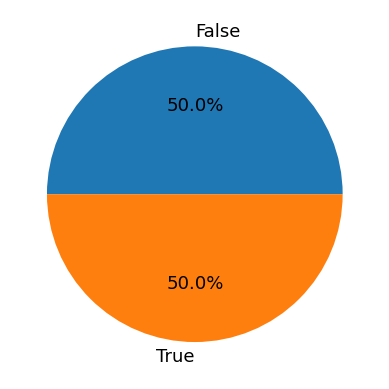

Accuracy: 0.777712412807799
Confusion Matrix:
 [[9208 2607]
 [  38   46]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.78      0.87     11815
        True       0.02      0.55      0.03        84

    accuracy                           0.78     11899
   macro avg       0.51      0.66      0.45     11899
weighted avg       0.99      0.78      0.87     11899

Average Precision: 0.019662392334461862
Recall at 100: 0.03571428571428571
ROC AUC: 0.7158157507607359


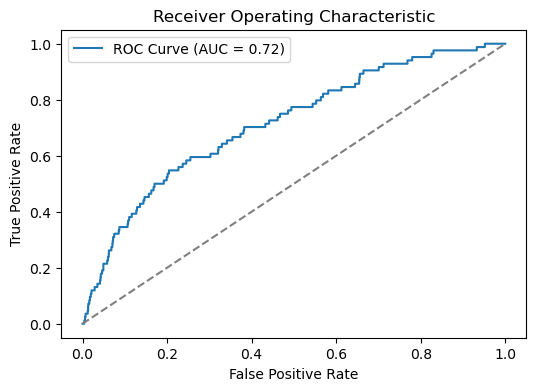

In [26]:

# Split into Train and Test using 'bankruptcy_prediction_split'
train_df = df[df['bankruptcy_prediction_split'] == 'train']
test_df  = df[df['bankruptcy_prediction_split'] == 'test']

# Define X and y for each split
#    Remove the 'bankruptcy_prediction_split' column before modeling
X_train = train_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_train = train_df['label']

X_test = test_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_test = test_df['label']

# Dealing with class imbalance
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Fit SMOTE on the training data to oversample the minority class
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
oversampled = pd.concat([pd.DataFrame(y_train_res), pd.DataFrame(X_train_res)], axis=1)

df.groupby('label').size().plot(kind='pie',
                                       autopct='%.1f%%',
                                       fontsize=13)
plt.show()

oversampled.groupby('label').size().plot(kind='pie',
                                       autopct='%.1f%%',
                                       fontsize=13)
                                    #    labels=['bankrupt','not bankrupt'],
                                    #    colors=['skyblue', 'tomato'])
plt.show()

# Create and fit the LR model
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_res, y_train_res)

# 6. Predict on the test set
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]  # Probabilities for positive class

evaluate_lr(y_pred, y_proba, y_test)





In [4]:
# df = pd.read_csv("../outputs/ecl_companyfacts_processed.csv")
# print("before drop na: ", df.shape)
# label_frequency_date_1 = df["label"].sum()
# cols_to_drop = ['bankruptcy_prediction_split', 'filename', 'period_of_report', 'gvkey', 'datadate', 'can_label', 'qualified', 'bankruptcy_date_1', 'bankruptcy_date_2', 'bankruptcy_date_3', 'filing_date', 'cik_year', 'opinion_text'] 
# df.drop(columns=cols_to_drop, inplace=True, errors='ignore')


# print(f"Label frequency for label (before drop): {label_frequency_date_1} / {len(df)}")

# print("Number of NaNs in 'item_7':", df['item_7'].isna().sum())
# print("Number of empty strings in 'item_7':", (df['item_7'] == "").sum())
# # df = df.dropna(subset=['item_7'])
# df.dropna(inplace=True)
# print("shape after drop: ", df.shape)
# label_frequency_date_1 = df["label"].sum()
# print(f"Label frequency for label: {label_frequency_date_1} / {len(df)}")

before drop na:  (21740, 26)
Label frequency for label (before drop): 133 / 21740
Number of NaNs in 'item_7': 134
Number of empty strings in 'item_7': 0
shape after drop:  (21606, 13)
Label frequency for label: 132 / 21606


## Logistic Regression (Numeric Cols + item_7 text)

In [36]:
# Read Dataset
# df = pd.read_csv(config.POST_PROCESSED_DATASET_FILEPATH)
# df = pd.read_json("../data/ECL_AA_subset.json", lines=True)
# print("Starting Shape of test set: ", df[df['bankruptcy_prediction_split'] == 'test'].shape)
# print("Label counts of test set: ", df[df['bankruptcy_prediction_split'] == 'test'].value_counts(subset=['label']))


Starting Shape of test set:  (18275, 7)
Label counts of test set:  label
False    18153
True       122
Name: count, dtype: int64


Starting Shape:  (21740, 15)
Label counts on the test set, before drop na:  label
False    11815
True        84
Name: count, dtype: int64
After dropping NAs from item_7 and opinion_text:  (21606, 15)
Label counts on the test set, after drop na:  label
False    11762
True        84
Name: count, dtype: int64
Accuracy: 0.9846361641060274
Confusion Matrix:
 [[11630   132]
 [   50    34]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      0.99     11762
        True       0.20      0.40      0.27        84

    accuracy                           0.98     11846
   macro avg       0.60      0.70      0.63     11846
weighted avg       0.99      0.98      0.99     11846

Average Precision: 0.21415398739231353
Recall at 100: 0.38095238095238093
ROC AUC: 0.9014360207609656


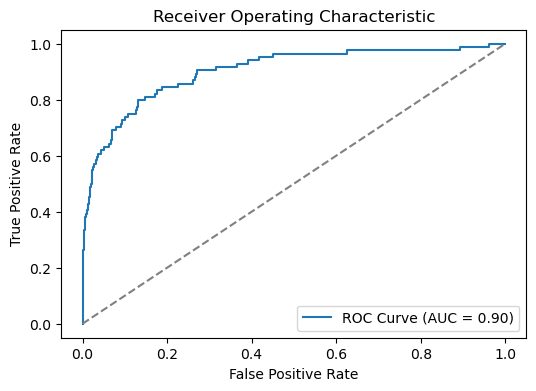

In [37]:
df = pd.read_csv(config.POST_PROCESSED_DATASET_FILEPATH)

cols_to_drop = [
    'filename', 'period_of_report', 'gvkey', 'datadate',
    'can_label', 'qualified', 'bankruptcy_date_1', 'bankruptcy_date_2',
    'bankruptcy_date_3', 'filing_date', 'cik_year'
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Drop rows where 'item_7' or 'opinion_text' is NA (if desired)
print("Starting Shape: ", df.shape)
print("Label counts on the test set, before drop na: ", df[df['bankruptcy_prediction_split'] == 'test'].value_counts(subset=['label']))
df = df.dropna(subset=['item_7', 'opinion_text'])
print("After dropping NAs from item_7 and opinion_text: ", df.shape)
print("Label counts on the test set, after drop na: ", df[df['bankruptcy_prediction_split'] == 'test'].value_counts(subset=['label']))

# Separate Target
y = df['label'].astype(int)

# Split into Train and Test using 'bankruptcy_prediction_split'
train_df = df[df['bankruptcy_prediction_split'] == 'train']
test_df  = df[df['bankruptcy_prediction_split'] == 'test']

# Define X and y for each split
#    Remove the 'bankruptcy_prediction_split' column before modeling
X_train = train_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_train = train_df['label']

X_test = test_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_test = test_df['label']

# Identify Numeric and Text Columns
numeric_cols = X_train.select_dtypes(include=['int', 'float']).columns
text_cols = ['item_7', 'opinion_text']  # We'll transform both text features

# Build a ColumnTransformer
#    - TF-IDF Vectorizer for each text column (removing English stopwords)
#    - StandardScaler for numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ("item_7_tfidf", TfidfVectorizer(max_features=5000, stop_words='english'), "item_7"),
        ("opinion_text_tfidf", TfidfVectorizer(max_features=5000, stop_words='english'), "opinion_text"),
        ("num", StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)

# Create a Pipeline
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(sampling_strategy='minority', random_state=42)),
    ("clf", LogisticRegression(max_iter=1000))
])

# Fit the Pipeline on the Training Data
pipeline.fit(X_train, y_train)

# Predict on the Test Set
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Evaluate Results
evaluate_lr(y_pred, y_proba, y_test)



In [51]:
# df = pd.read_json("../outputs/ecl_companyfacts.json", lines=True)

print("Bankruptcy label distribution:")
print(df[df['bankruptcy_prediction_split'] == 'test'].value_counts(subset=['label']))

test_df  = df[df['bankruptcy_prediction_split'] == 'test']

print(test_df[test_df['label'] == None])

X_test = test_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_test = test_df['label']

print(X_test.isna().sum(axis=0))


# Predict on the Test Set
# y_pred = pipeline.predict(X_test)
# y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# # Evaluate Results
# evaluate_lr(y_pred, y_proba, y_test)


Bankruptcy label distribution:
label
False    17125
True       110
Name: count, dtype: int64
Empty DataFrame
Columns: [cik, company, period_of_report, gvkey, datadate, filename, can_label, qualified, label, bankruptcy_prediction_split, bankruptcy_date_1, bankruptcy_date_2, bankruptcy_date_3, filing_date, cik_year, opinion_text, gc_list, item_7, AccountsPayableCurrent, AccountsReceivableNetCurrent, AccruedLiabilitiesCurrent, AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment, AccumulatedOtherComprehensiveIncomeLossNetOfTax, AdditionalPaidInCapitalCommonStock, AdjustmentsToAdditionalPaidInCapitalTaxEffectFromShareBasedCompensation, AmortizationOfDebtDiscountPremium, AssetImpairmentCharges, Assets, AssetsCurrent, AssetsNoncurrent, BuildingsAndImprovementsGross, CapitalLeaseObligationsCurrent, CapitalLeaseObligationsNoncurrent, CashAndCashEquivalentsAtCarryingValue, CashAndCashEquivalentsPeriodIncreaseDecrease, CommonStockParOrStatedValuePerShare, CommonStockSharesAut

In [ ]:

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

evaluate_lr(y_pred, y_proba, y_test)


In [ ]:
train_df = df[df['bankruptcy_prediction_split'] == 'train']
test_df  = df[df['bankruptcy_prediction_split'] == 'test']

X_train = train_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_train = train_df['label']

X_test = test_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_test = test_df['label']

print(train_df.shape, test_df.shape)
print(y_train.value_counts())
print(y_test.value_counts())

In [12]:

text_cols = ['item_7', 'opinion_text']
numeric_cols = X_train.select_dtypes(include=['int', 'float']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("item_7_tfidf", TfidfVectorizer(max_features=5000, stop_words='english'), "item_7"),
        ("opinion_text_tfidf", TfidfVectorizer(max_features=5000, stop_words='english'), "opinion_text"),
        ("num", StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)

# 1. Fit the preprocessor on the training data (TF-IDF is unsupervised, so only X is needed)
preprocessor.fit(X_train)

# 2. Transform X_train
X_train_pre = preprocessor.transform(X_train)
# 3. Transform X_test (use the same fitted preprocessor)
X_test_pre = preprocessor.transform(X_test)

print("X_train_pre shape:", X_train_pre.shape)
print("X_test_pre shape:", X_test_pre.shape)

X_train_pre shape: (9760, 10009)
X_test_pre shape: (11846, 10009)
